In [4]:
import fastai
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.script import *
from skimage import filters
from skimage.util import random_noise

In [5]:
# Modify accordingly
path = Path('/home/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/')

dataset_name = 'semi-synthetic_tSEM'

lr_name = f'training/trainsets/crappified/'
lr_path = path/f'{lr_name}'
lr_files = list(lr_path.glob('*.tif'))

hr_name = f'training/trainsets/hr/'
hr_path = path/f'{hr_name}'
hr_files = list(hr_path.glob('*.tif'))

print('Processing '+str(len(lr_files))+' files...')

Processing 99997 files...


In [6]:
def get_data(x_train, y_train, mode='L'):
    def map_to_hr(x):
        return Path(str(y_train/x.relative_to(x_train).with_suffix(".tif")).replace('lr', 'hr'))
    src = (ImageImageList
          .from_folder(x_train, convert_mode=mode)
          .split_none()
          .label_from_func(map_to_hr, convert_mode=mode))
    return src

In [7]:
d = get_data(lr_path, hr_path)

In [8]:
d.train

LabelList (99997 items)
x: ImageImageList
Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225),Image (1, 150, 225)
y: ImageList
Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900),Image (1, 600, 900)
Path: /home/alaa/Dropbox (BPHO)/BPHO Staff/USF/EM/training/trainsets/crappified

In [9]:
def _my_noise(x, gauss_sigma:uniform=0.01, pscale:uniform=10):
    xn = x.numpy()
    xorig_max = xn.max()

    xn = random_noise(xn, mode='salt', amount=0.005)
    xn = random_noise(xn, mode='pepper', amount=0.005)
    lvar = filters.gaussian(x, sigma=5) + 1e-10
    xn = random_noise(xn, mode='localvar', local_vars=lvar*0.5)
    #xn = np.random.poisson(xn*pscale)/pscale
    #xn += np.random.normal(0, gauss_sigma*xn.std(), size=x.shape)
    x = x.new(xn)
    new_max = xn.max()
    if new_max > 0:
        xn /= new_max
    xn *= xorig_max
    return x


my_noise = TfmPixel(_my_noise)

In [10]:
def get_xy_transforms(max_rotate=10., min_zoom=1., max_zoom=4., use_cutout=False, use_noise=False, xtra_tfms=None,
                      gauss_sigma=(0.4,0.7), pscale=(5,30)):
    base_tfms = [[
            rand_crop(),
            dihedral_affine(),
            rotate(degrees=(-max_rotate,max_rotate)),
            rand_zoom(min_zoom, max_zoom)],
        [crop_pad()]]

    y_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    x_tfms = [[tfm for tfm in base_tfms[0]], [tfm for tfm in base_tfms[1]]]
    if use_cutout: x_tfms[0].append(cutout(n_holes=(5,10)))
    if use_noise:
        x_tfms[0].append(my_noise(gauss_sigma=gauss_sigma, pscale=pscale))
        #x_tfms[1].append(my_noise(gauss_sigma=(0.01,0.05),pscale=(5,30)))

    if xtra_tfms:
        for tfm in xtra_tfms:
            x_tfms[0].append(tfm)

    return x_tfms, y_tfms

In [11]:
def process_data(data, bs=8, size=256, scale=4, num_workers=4):
    x_tfms, y_tfms = get_xy_transforms()
    x_sz = size // scale
    
    data = (data.transform(x_tfms, size=x_sz)
               .transform_y(y_tfms, size=size)
               .databunch(bs=bs, num_workers=num_workers)
               .normalize(do_y=True))
    return data

In [12]:
db = process_data(d)

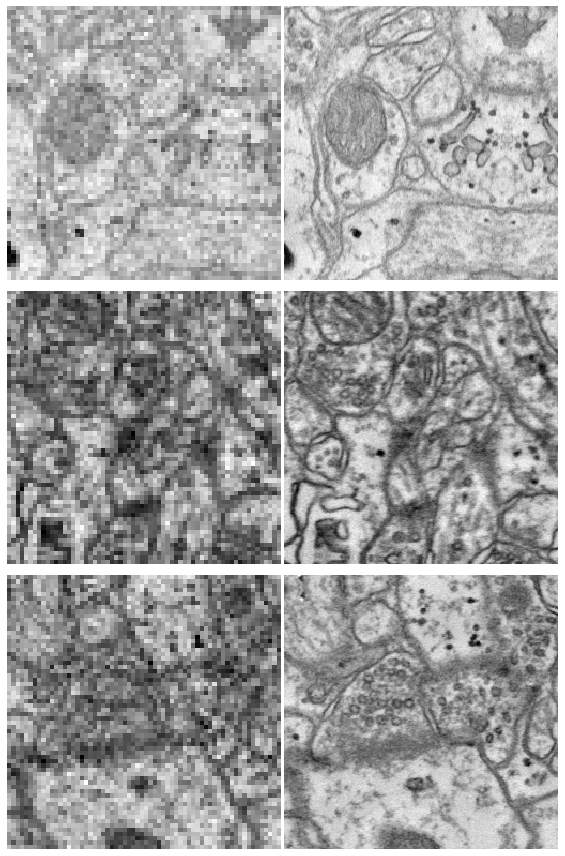

In [13]:
db.show_batch(rows=3, cmap=plt.cm.gray)

# resnet.py

In [20]:
from functools import partial
import fastai.vision.learner as fvl

In [56]:
act_fn = nn.ReLU(inplace=True)
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)
def conv(ni, nf, ks=3, stride=1, bias=False):
    return nn.Conv2d(ni, nf, kernel_size=ks, stride=stride, padding=ks//2, bias=bias)

def noop(x): return x

def conv_layer(ni, nf, ks=3, stride=1, act=True):
    layers = [nn.utils.weight_norm(conv(ni, nf, ks, stride=stride))]
    if act: layers.append(act_fn)
    return nn.Sequential(*layers)

class ResBlock(nn.Module):
    def __init__(self, expansion, ni, nh, stride=1):
        super().__init__()
        nf,ni = nh*expansion,ni*expansion
        layers  = [conv_layer(ni, nh, 1)]
        layers += [
            conv_layer(nh, nf, 3, stride=stride,act=False)
        ] if expansion==1 else [
            conv_layer(nh, nh, 3, stride=stride),
            conv_layer(nh, nf, 1, act=False)
        ]
        self.convs = nn.Sequential(*layers)
        # TODO: check whether act=True works better
        self.idconv = noop if ni==nf else conv_layer(ni, nf, 1, act=False)
        self.pool = noop if stride==1 else nn.AvgPool2d(2, ceil_mode=True)

    def forward(self, x): return act_fn(self.convs(x) + self.idconv(self.pool(x)))

def filt_sz(recep): return min(64, 2**math.floor(math.log2(recep*0.75)))

class WNResNet(nn.Sequential):
    def __init__(self, expansion, layers, c_in=3, c_out=1000):
        stem = []
        sizes = [c_in,32,32,64]
        for i in range(3):
            stem.append(conv_layer(sizes[i], sizes[i+1], stride=2 if i==0 else 1))
            #nf = filt_sz(c_in*9)
            #stem.append(conv_layer(c_in, nf, stride=2 if i==1 else 1))
            #c_in = nf

        block_szs = [64//expansion,64,128,256,512]
        blocks = [self._make_layer(expansion, block_szs[i], block_szs[i+1], l, 1 if i==0 else 2)
                  for i,l in enumerate(layers)]
        super().__init__(
            *stem,
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            *blocks,
            nn.AdaptiveAvgPool2d(1), Flatten(),
            nn.Linear(block_szs[-1]*expansion, c_out),
        )
        init_cnn(self)

    def _make_layer(self, expansion, ni, nf, blocks, stride):
        return nn.Sequential(
            *[ResBlock(expansion, ni if i==0 else nf, nf, stride if i==0 else 1)
              for i in range(blocks)])

def wnresnet(expansion, n_layers, name, pretrained=False, **kwargs):
    model = WNResNet(expansion, n_layers, **kwargs)
    return model

def _wnresnet_split(m:nn.Module): return (m[0][6],m[1])
_wnresnet_meta     = {'cut':-2, 'split':_wnresnet_split }

In [46]:
name = 'wnresnet34'
# setattr(me, name, partial(wnresnet, expansion=e, n_layers=l, name=name))
# arch = getattr(me, name)
# fvl.model_meta[arch] = {**_wnresnet_meta}

In [47]:
e, l = 1, [3,4,6 ,3]

In [ ]:
arch = wnresnet()

In [48]:
arch = partial(wnresnet, expansion=e, n_layers=l, name=name)
fvl.model_meta[arch] = {**_wnresnet_meta}

# unet.py

In [49]:
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config

In [58]:
class BilinearWrapper(nn.Module):
    def __init__(self, model, scale=4, mode='bilinear'):
        super().__init__()
        self.model = model
        self.scale = scale
        self.mode = mode

    def forward(self, x):
        return self.model(F.interpolate(x, scale_factor=self.scale, mode=self.mode, align_corners=False))

In [50]:
def wnres_unet_model(in_c, out_c, arch, blur=True, blur_final=True, self_attention=True, last_cross=True, bottle=True, norm_type=NormType.Weight, **wnres_args):
    meta = cnn_config(arch)
    enc_model = arch(c_in=in_c)
    cut = cnn_config(arch)['cut']
    body = nn.Sequential(*list(enc_model.children())[:cut])

    model = DynamicUnet(body,
                        n_classes=out_c,
                        blur=blur,
                        blur_final=blur_final,
                        self_attention=self_attention,
                        norm_type=norm_type,
                        last_cross=last_cross,
                        bottle=bottle, **wnres_args)
    return model, meta


def wnres_unet_learner(data, arch, in_c=1, out_c=1, wnres_args=None, bilinear_upsample=True, **kwargs):
    if wnres_args is None: wnres_args = {}
    model, meta = wnres_unet_model(in_c, out_c, arch, **wnres_args)
    learn = Learner(data, model, **kwargs)
    learn.split(meta['split'])
    apply_init(model[2], nn.init.kaiming_normal_)
    if bilinear_upsample:
        learn.model = BilinearWrapper(learn.model)
    return learn

# train.py

In [51]:
import torch.nn.functional as F
loss = F.mse_loss 

In [52]:
wnres_args = {
            'blur': True,
            'blur_final': True,
            'bottle': True,
            'self_attention': True,
            'last_cross': True
        }
wd = 1e-3

In [53]:
model_dir = './model/test'

In [54]:
callback_fns = []
save_name = 'combo'
size = 256
callback_fns.append(partial(SaveModelCallback, name=f'{save_name}_best_{size}'))

In [59]:
learn = wnres_unet_learner(db, arch, wnres_args=wnres_args,
                                       path=Path('.'), loss_func=loss, metrics=metrics,
                                       model_dir=model_dir, callback_fns=callback_fns, wd=wd)

In [60]:
lr = slice(None, 1e-4, None)

In [ ]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,fastai.metrics,time


In [ ]:
learn.lr_find()